In [1]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 22.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem
from rdkit.DataStructs import cDataStructs
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

#**Upload Bioactivity data (pIC50) of molecules (smiles)**

In [3]:

df = pd.read_csv('Bioactivity_Data_clean.csv')
df

,Smiles,pIC50
0,CCCS(=O)(=O)Nc1ccc(F)c(C(=O)c2c[nH]c3ncc(-c4cc...,4.779892
1,Cc1[nH]c2cc(Cl)cc(Cl)c2c1CCN,3.809668
2,N#Cc1ccc2c(c1)CN(S(=O)(=O)c1cccs1)[C@H](Cc1ccc...,5.638272
3,CCn1c(=O)c(-c2ccc(F)c(NC(=O)Nc3cc(C(C)(C)C)no3...,7.040959
4,CCn1c(=O)c(-c2cc(NC(=O)NCCC(C)(C)C)c(F)cc2C)cc...,6.920819
...,...,...
76,Cc1cc(N)nc(-c2cc3nc(OC[C@@H]4CCCN4C)nc4c3c(c2C...,5.619789
77,Cc1cc(N)nc(-c2cc3nc(OC[C@@H]4CCCN4C)nc4c3c(c2C...,5.086186
78,Cc1cc(N)nc(-c2cc3nc(OC[C@@H]4CCCN4C)nc4c3c(c2C...,5.677781
79,Cc1cc(N)nc(-c2cc3nc(OC[C@@H]4CCCN4C)nc4c3c(c2C...,5.619789


In [4]:
df = df.dropna ()
df

,Smiles,pIC50
0,CCCS(=O)(=O)Nc1ccc(F)c(C(=O)c2c[nH]c3ncc(-c4cc...,4.779892
1,Cc1[nH]c2cc(Cl)cc(Cl)c2c1CCN,3.809668
2,N#Cc1ccc2c(c1)CN(S(=O)(=O)c1cccs1)[C@H](Cc1ccc...,5.638272
3,CCn1c(=O)c(-c2ccc(F)c(NC(=O)Nc3cc(C(C)(C)C)no3...,7.040959
4,CCn1c(=O)c(-c2cc(NC(=O)NCCC(C)(C)C)c(F)cc2C)cc...,6.920819
...,...,...
76,Cc1cc(N)nc(-c2cc3nc(OC[C@@H]4CCCN4C)nc4c3c(c2C...,5.619789
77,Cc1cc(N)nc(-c2cc3nc(OC[C@@H]4CCCN4C)nc4c3c(c2C...,5.086186
78,Cc1cc(N)nc(-c2cc3nc(OC[C@@H]4CCCN4C)nc4c3c(c2C...,5.677781
79,Cc1cc(N)nc(-c2cc3nc(OC[C@@H]4CCCN4C)nc4c3c(c2C...,5.619789


#**FingerPrint & 2D Descriptors**

In [29]:
from rdkit.Chem.rdmolops import PatternFingerprint
from rdkit.Chem import rdFingerprintGenerator


def predict_bioactivity(smiles):
    m = Chem.MolFromSmiles(smiles)
    desc = []

    # Calculate atom pair fingerprint using AtomPairGenerator
    fp_generator = rdFingerprintGenerator.GetAtomPairGenerator()
    fp = fp_generator.GetFingerprint(m)
    desc.extend([int(x) for x in fp.ToBitString()])

    # Calculate RDK fingerprint
    fp = Chem.RDKFingerprint(m)
    desc.extend(fp)

    # Calculate additional molecular descriptors
    desc.append(Descriptors.MolWt(m))
    desc.append(Descriptors.MolLogP(m))
    desc.append(rdMolDescriptors.CalcNumHBA(m))
    desc.append(rdMolDescriptors.CalcNumHBD(m))
    desc.append(Descriptors.TPSA(m))
    desc.append(rdMolDescriptors.CalcFractionCSP3(m))
    desc.append(rdMolDescriptors.CalcNumRotatableBonds(m))
    desc.append(rdMolDescriptors.CalcNumAromaticRings(m))
    desc.append(rdMolDescriptors.CalcNumHeterocycles(m))

    return desc

In [5]:

descriptors = []
for i, row in df.iterrows():
    m = Chem.MolFromSmiles(str(row["Smiles"]))
    desc = []

    # calculate hashed atom pair fingerprint
    fp = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(m)
    desc.extend([int(x) for x in fp.ToBitString()])

    # calculate RDK fingerprint
    fp = Chem.RDKFingerprint(m)
    desc.extend(fp)

    # calculate additional molecular descriptors
    desc.append(Descriptors.MolWt(m))
    desc.append(Descriptors.MolLogP(m))
    desc.append(rdMolDescriptors.CalcNumHBA(m))
    desc.append(rdMolDescriptors.CalcNumHBD(m))
    desc.append(Descriptors.TPSA(m))
    desc.append(rdMolDescriptors.CalcFractionCSP3(m))
    desc.append(rdMolDescriptors.CalcNumRotatableBonds(m))
    desc.append(rdMolDescriptors.CalcNumAromaticRings(m))
    desc.append(rdMolDescriptors.CalcNumHeterocycles(m))

    descriptors.append(desc)


[01:05:05] DEPRECATION WARNING: please use AtomPairGenerator
[01:05:05] DEPRECATION WARNING: please use AtomPairGenerator
[01:05:05] DEPRECATION WARNING: please use AtomPairGenerator
[01:05:05] DEPRECATION WARNING: please use AtomPairGenerator
[01:05:05] DEPRECATION WARNING: please use AtomPairGenerator
[01:05:05] DEPRECATION WARNING: please use AtomPairGenerator
[01:05:05] DEPRECATION WARNING: please use AtomPairGenerator
[01:05:05] DEPRECATION WARNING: please use AtomPairGenerator
[01:05:05] DEPRECATION WARNING: please use AtomPairGenerator
[01:05:05] DEPRECATION WARNING: please use AtomPairGenerator
[01:05:05] DEPRECATION WARNING: please use AtomPairGenerator
[01:05:05] DEPRECATION WARNING: please use AtomPairGenerator
[01:05:05] DEPRECATION WARNING: please use AtomPairGenerator
[01:05:05] DEPRECATION WARNING: please use AtomPairGenerator
[01:05:05] DEPRECATION WARNING: please use AtomPairGenerator
[01:05:05] DEPRECATION WARNING: please use AtomPairGenerator
[01:05:05] DEPRECATION W

In [30]:
# Convert the descriptors list to a Pandas dataframe
df2 = pd.DataFrame(descriptors)
df2.to_csv('decriptors.csv', index=False)
df2

,0,1,2,3,4,5,6,7,8,9,...,4095,4096,4097,4098,4099,4100,4101,4102,4103,4104
0,1,1,0,0,1,1,1,0,0,0,...,1,489.931,5.54420,4,2,91.92,0.130435,7,4,2
1,0,0,0,0,1,0,0,0,0,0,...,1,243.137,3.28432,1,2,41.81,0.272727,2,2,1
2,1,1,1,1,1,1,0,0,0,0,...,1,489.626,4.16528,6,1,93.09,0.200000,6,4,3
3,1,0,0,0,1,0,0,0,0,0,...,1,478.528,5.19370,7,3,114.08,0.280000,5,4,3
4,1,1,0,0,1,1,0,0,0,0,...,1,453.562,5.13032,5,3,88.05,0.400000,6,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,1,1,1,0,1,1,1,1,1,1,...,1,673.140,3.74672,10,2,121.97,0.562500,5,3,6
77,1,1,0,0,1,1,1,1,1,1,...,1,663.145,4.08732,10,1,113.18,0.548387,6,3,5
78,1,1,0,0,1,1,1,1,1,1,...,1,689.183,4.52692,10,2,121.97,0.575758,7,3,6
79,1,1,1,0,1,1,1,1,1,1,...,1,701.194,4.52692,10,2,121.97,0.588235,5,3,6


In [31]:
X = df2
y = df["pIC50"]

#**Split data into training and test sets**

In [32]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


# **QSAR Modell RandomForestRegressor**

In [33]:
# train QSAR model
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

RandomForestRegressor(random_state=42)

In [34]:
# predict bioactivity on test set
y_pred = model.predict(X)

In [40]:
# evaluate model performance
print("R^2:", model.score(X_test, y_test))

R^2: 0.9735494323593402


In [36]:
import matplotlib.pyplot as plt
import numpy as np

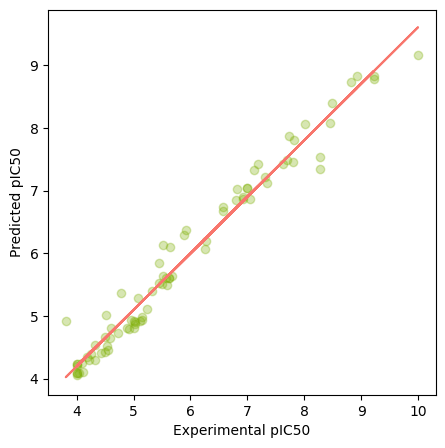

In [37]:
plt.figure(figsize=(5,5))
plt.scatter(x=y, y=y_pred, c="#7CAE00", alpha=0.3)

z = np.polyfit(y, y_pred, 1)
p = np.poly1d(z)

plt.plot(y,p(y),"#F8766D")
plt.ylabel('Predicted pIC50')
plt.xlabel('Experimental pIC50')
plt.savefig('regression_curve.pdf')

#**Define a function to calculate the descriptors of a new molecule (SINGLE) and Predict pIC50**

In [47]:
from rdkit.Chem.rdmolops import PatternFingerprint
from rdkit.Chem import rdFingerprintGenerator

def predict_bioactivity(smiles):
    m = Chem.MolFromSmiles(smiles)
    desc = []

    # Calculate atom pair fingerprint using AtomPairGenerator
    fp_generator = rdFingerprintGenerator.GetAtomPairGenerator()
    fp = fp_generator.GetFingerprint(m)
    desc.extend([int(x) for x in fp.ToBitString()])

    # Calculate RDK fingerprint
    fp = Chem.RDKFingerprint(m)
    desc.extend(fp)

    # Calculate additional molecular descriptors
    desc.append(Descriptors.MolWt(m))
    desc.append(Descriptors.MolLogP(m))
    desc.append(rdMolDescriptors.CalcNumHBA(m))
    desc.append(rdMolDescriptors.CalcNumHBD(m))
    desc.append(Descriptors.TPSA(m))
    desc.append(rdMolDescriptors.CalcFractionCSP3(m))
    desc.append(rdMolDescriptors.CalcNumRotatableBonds(m))
    desc.append(rdMolDescriptors.CalcNumAromaticRings(m))
    desc.append(rdMolDescriptors.CalcNumHeterocycles(m))

    return desc

# predict bioactivity of new molecule (Sotorasib)
smiles = "C[C@H]1CN(CCN1C2=NC(=O)N(C3=NC(=C(C=C32)F)C4=C(C=CC=C4F)O)C5=C(C=CN=C5C(C)C)C)C(=O)C=C"
X_new = np.array(predict_bioactivity(smiles)).reshape(1, -1)

# Print the selected features
#print(selected_features)
bioactivity = model.predict(X_new)
print("Predicted bioactivity (pIC50):", bioactivity)

pIC50 = bioactivity
IC50 = (10**-pIC50)*(10**9)
print("IC50:", IC50, "nM")

Predicted bioactivity (pIC50): [6.99512555]
IC50: [101.12870599] nM


In [48]:
from rdkit.Chem.rdmolops import PatternFingerprint
from rdkit.Chem import rdFingerprintGenerator

def predict_bioactivity(smiles):
    m = Chem.MolFromSmiles(smiles)
    desc = []

    # Calculate atom pair fingerprint using AtomPairGenerator
    fp_generator = rdFingerprintGenerator.GetAtomPairGenerator()
    fp = fp_generator.GetFingerprint(m)
    desc.extend([int(x) for x in fp.ToBitString()])

    # Calculate RDK fingerprint
    fp = Chem.RDKFingerprint(m)
    desc.extend(fp)

    # Calculate additional molecular descriptors
    desc.append(Descriptors.MolWt(m))
    desc.append(Descriptors.MolLogP(m))
    desc.append(rdMolDescriptors.CalcNumHBA(m))
    desc.append(rdMolDescriptors.CalcNumHBD(m))
    desc.append(Descriptors.TPSA(m))
    desc.append(rdMolDescriptors.CalcFractionCSP3(m))
    desc.append(rdMolDescriptors.CalcNumRotatableBonds(m))
    desc.append(rdMolDescriptors.CalcNumAromaticRings(m))
    desc.append(rdMolDescriptors.CalcNumHeterocycles(m))

    return desc

# predict bioactivity of new molecule (Adagrasib)
smiles = "CN1CCC[C@H]1COC2=NC3=C(CCN(C3)C4=CC=CC5=C4C(=CC=C5)Cl)C(=N2)N6CCN([C@H](C6)CC#N)C(=O)C(=C)F"
X_new = np.array(predict_bioactivity(smiles)).reshape(1, -1)

# Print the selected features
#print(selected_features)
bioactivity = model.predict(X_new)
print("Predicted bioactivity (pIC50):", bioactivity)

pIC50 = bioactivity
IC50 = (10**-pIC50)*(10**9)
print("IC50:", IC50, "nM")

Predicted bioactivity (pIC50): [7.57895588]
IC50: [26.36599243] nM


#**Convert pIC50 to IC50 (nm)**

In [43]:
pIC50 = bioactivity
IC50 = (10**-pIC50)*(10**9)
print("IC50:", IC50, "nM")

IC50: [1325.46668338] nM


# **Define a function to calculate the descriptors of a new set of molecules (smiles.csv) and Predict pIC50 (predicted_ic50.csv).    smiles.csv file should have "Compound ID" and "Smiles" columns.**

In [38]:
from rdkit.Chem.rdmolops import PatternFingerprint
from rdkit.Chem import rdFingerprintGenerator

def predict_bioactivity(smiles):
    m = Chem.MolFromSmiles(smiles)
    desc = []

    # Calculate atom pair fingerprint using AtomPairGenerator
    fp_generator = rdFingerprintGenerator.GetAtomPairGenerator()
    fp = fp_generator.GetFingerprint(m)
    desc.extend([int(x) for x in fp.ToBitString()])

    # Calculate RDK fingerprint
    fp = Chem.RDKFingerprint(m)
    desc.extend(fp)

    # Calculate additional molecular descriptors
    desc.append(Descriptors.MolWt(m))
    desc.append(Descriptors.MolLogP(m))
    desc.append(rdMolDescriptors.CalcNumHBA(m))
    desc.append(rdMolDescriptors.CalcNumHBD(m))
    desc.append(Descriptors.TPSA(m))
    desc.append(rdMolDescriptors.CalcFractionCSP3(m))
    desc.append(rdMolDescriptors.CalcNumRotatableBonds(m))
    desc.append(rdMolDescriptors.CalcNumAromaticRings(m))
    desc.append(rdMolDescriptors.CalcNumHeterocycles(m))

    return desc

# Function to process a CSV file and predict IC50 for each compound
def predict_ic50_from_csv(csv_file, model, output_file):
    # Read the CSV file
    data = pd.read_csv(csv_file)
    smiles_list = data['Smiles']  # Assumes the SMILES column is named 'Smiles'

    # Initialize results
    results = []

    for idx, smiles in enumerate(smiles_list):
        try:
            # Calculate descriptors
            desc = predict_bioactivity(smiles)
            X_new = np.array(desc).reshape(1, -1)

            # Predict pIC50
            pIC50 = model.predict(X_new)[0]  # Assuming model outputs a single value

            # Convert pIC50 to IC50 (nM)
            IC50 = (10 ** -pIC50) * (10 ** 9)

            # Append results
            results.append({
                'Compound ID': data.loc[idx, 'Compound ID'],  # Assumes a 'Compound ID' column
                'SMILES': smiles,
                'Predicted pIC50': pIC50,
                'Predicted IC50 (nM)': IC50
            })
        except Exception as e:
            print(f"Error processing SMILES {smiles}: {e}")
            results.append({
                'Compound ID': data.loc[idx, 'Compound ID'],
                'Smiles': smiles,
                'Predicted pIC50': None,
                'Predicted IC50 (nM)': None
            })

    # Save results to a CSV file
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_file, index=False)
    print(f"Predictions saved to {output_file}")

# Example usage
csv_file = "smiles.csv"  # Input CSV file
output_file = "predicted_ic50.csv"  # Output CSV file
predict_ic50_from_csv(csv_file, model, output_file)


Predictions saved to predicted_ic50.csv
